In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import ast
import base64
import torch
import textstat
import numpy as np
import pandas as pd
from tqdm import tqdm
import datasets as ds
from collections import defaultdict
import matplotlib.pyplot as plt
from huggingface_hub import login
from transformers import pipeline

HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN", None)
if HUGGINGFACE_TOKEN is not None:
    login(token=HUGGINGFACE_TOKEN)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-17 19:28:04.239260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 19:28:04.239290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 19:28:04.240306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 19:28:04.245195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
torch.manual_seed(42)

#### Loading the test dataset

In [5]:
dataset = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_test_set_100_model_generated")
display(dataset)
display(dataset[0])

Dataset({
    features: ['question_created_utc', 'question_retrieved_on', 'question_deleted', 'question_title', 'question_selftext', 'question_score', 'question_char_length', 'question_selftext_char_length', 'answers', 'graded_output', 'Zephyr-7B-beta', 'Zephyr-History-7600'],
    num_rows: 100
})

{'question_created_utc': 1664471496000,
 'question_retrieved_on': 1665428342000,
 'question_deleted': False,
 'question_title': 'Who were some early/Renaissance philosophers who believed that all human beings were essentially the same, with all concepts of race being pseudoscience?',
 'question_selftext': 'The historical record is filled with examples of race science and people employing racial categorizations to describe people. But underlying all of that has been a scientific truth: from a scientific perspective, every human being is essentially equal. Races do not inherently exist in the human body. Cultures do not inherently exist. Those things are all constructed by whatever society a person happens to live in. The march of science would ultimately provide no more specificity than “Homo sapiens”.\n\nI realized that I don’t really have any examples of early philosophers who believed this. Outside of the American abolition movement, I don’t know of anyone who taught against racial c

In [6]:
df = pd.DataFrame(dataset)
df["Reddit"] = df["answers"].apply(lambda x: x[0]["answer_body"])
df = df[[c for c in df.columns if (c == "question_title" or not c.startswith("question_")) and not c == "graded_output" and not c == "answers"]]
df.rename(columns={"question_title": "question"}, inplace=True)
df.columns = [c + ".answer" if c != "question" else c for c in df.columns]
df

,question,Zephyr-7B-beta.answer,Zephyr-History-7600.answer,Reddit.answer
0,Who were some early/Renaissance philosophers w...,"2) Thomas Paine, John Locke, and Baruch Spinoz...",The most famous example of this is Girolamo S...,There are two threads of thought that one can ...
1,In the United States many poorer States tend t...,1. Republican-led states have generally admini...,This is a complex question. The United States...,The USA is fairly unique among nations in term...
2,Are there any good sources on the internet tha...,"\n\nYes, here are a few sources you might find...",I'll share some good sources with you. First ...,Here's a [review]([LINK] of two books that dea...
3,Why did Carpathian Ruthenia become part of Cze...,"\n\nAfter World War I, the Allied Powers (main...","This question comes up every few years, and I...",1/4\n\nI will first describe the situation of ...
4,Did Alexander the Great ever intended to conqu...,Alexander the Great initially set his sights ...,This is a frequent question. The Persian Empi...,The answer is yes. Or perhaps no. Bear with me...
...,...,...,...,...
95,Did Black British soldiers fight on the wester...,"20,000 spent two or three years fighting in Fr...",The British Expeditionary Forces (BEF) that f...,They were allowed and did fight. See my previo...
96,Historically how did muslim south east asians ...,"On early records, during Mughal times, when t...",This is a complex question but I'll try to hi...,The recent explosion in the number of Hajji da...
97,What waterproof clothing did they have in the ...,"\n\nIn the past, sailors wore woolen clothes, ...",The past is a long time and water is a comple...,Oilskins. Soak linen or canvas with linseed oi...
98,Is there evidence of atheist neolithic peoples...,No evidence exists to support this claim.\n\n...,The closest you can get is in [The Forgotten ...,"Im sorry, but your question goes against the m..."


#### Textstat and toxicity scores

In [7]:
toxicity_pipe = pipeline("text-classification", model="tomh/toxigen_roberta", device='cuda:0')


def mean_std(col, precision=2): 
    col_mean = col.mean()
    col_std = col.std()
    return f'{col_mean:.{precision}f} ± {col_std:.{precision}f}'


def run_toxicity_pipe(text):
    try: 
        result = toxicity_pipe(text, top_k=None)
        result = [r for r in result if r['label'] == 'LABEL_1'][0]
    except:
        return 0.5

    return result['score']


metrics_list = []
for col in df.columns:

    if not col.endswith('.answer'):
        continue

    name = col.replace('.answer', '')

    # Apply textstat functions
    text_standard = df[col].apply(lambda t: textstat.text_standard(t, float_output=True))
    reading_time = df[col].apply(textstat.reading_time)
    df[name + '.text_standard'] = text_standard
    df[name + '.reading_time'] = reading_time

    # Measure toxicity
    toxicity = df[col].apply(run_toxicity_pipe)

    # Measure answer length 
    answer_length = df[col].apply(len)

    # Save metrics
    metrics_list.append({
        'name': name,
        'text_standard [grade]': mean_std(text_standard),
        'reading_time [s]': mean_std(reading_time),
        'toxicity [0-1]': mean_std(toxicity, precision=3),
        'answer_length [chars]': mean_std(answer_length),
    })

    # Print metrics
    print(f'{name}:')
    print('\n'.join([f'  {k}: {v}' for k, v in metrics_list[-1].items()]))


Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Zephyr-7B-beta:
  name: Zephyr-7B-beta
  text_standard [grade]: 13.17 ± 2.51
  reading_time [s]: 27.87 ± 14.02
  toxicity [0-1]: 0.182 ± 0.240
  answer_length [chars]: 2252.82 ± 1125.74


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Zephyr-History-7600:
  name: Zephyr-History-7600
  text_standard [grade]: 12.74 ± 3.15
  reading_time [s]: 16.10 ± 9.74
  toxicity [0-1]: 0.068 ± 0.166
  answer_length [chars]: 1316.96 ± 796.60


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Reddit:
  name: Reddit
  text_standard [grade]: 11.48 ± 3.72
  reading_time [s]: 29.45 ± 28.57
  toxicity [0-1]: 0.201 ± 0.248
  answer_length [chars]: 2412.68 ± 2339.75


In [8]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index('name').sort_index()
metrics_df.to_markdown('metrics_model_comparison.md')
metrics_df

,text_standard [grade],reading_time [s],toxicity [0-1],answer_length [chars]
name,,,,
Reddit,11.48 ± 3.72,29.45 ± 28.57,0.201 ± 0.248,2412.68 ± 2339.75
Zephyr-7B-beta,13.17 ± 2.51,27.87 ± 14.02,0.182 ± 0.240,2252.82 ± 1125.74
Zephyr-History-7600,12.74 ± 3.15,16.10 ± 9.74,0.068 ± 0.166,1316.96 ± 796.60


Review an example row

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(pd.DataFrame(df.iloc[6]))

6
question                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### Data for Human Annotators 

Generate sheet to compare models for human annotators. We focus on the baseline and the two checkpoints after 2500 and 8500 steps. We compare to the left and make sure that the order is randomized

In [10]:
def encode_metadata(metadata):
    metadata = repr(metadata)
    metadata = metadata.encode('utf-8')
    metadata = base64.b64encode(metadata)
    return metadata

def decode_metadata(metadata):
    metadata = metadata[2:-1]  # remove b' and '
    metadata = base64.b64decode(metadata)
    metadata = metadata.decode('utf-8')
    metadata = ast.literal_eval(metadata)
    return metadata

In [11]:
def create_comparison(col1, col2): 

    # Create a new dataframe with the two columns
    comparisons = []

    for i, row in df.iterrows():

        question = row['question']
        answer1 = row[col1]
        answer2 = row[col2]

        do_swap = np.random.choice([True, False])


        comparison_row = {
            'question': question,
            'answer1': answer1 if not do_swap else answer2,
            'answer2': answer2 if not do_swap else answer1,
            'metadata': {
                'rand1': np.random.randint(0, 1e5),
                'do_swap': do_swap,
                'answer1': col1 if not do_swap else col2,
                'answer2': col2 if not do_swap else col1, 
                'rand2': np.random.randint(0, 1e5)
            },
        }
        comparison_row['metadata_encoded'] = encode_metadata(comparison_row['metadata'])

        comparisons.append(comparison_row)

    df_comparisons = pd.DataFrame.from_records(comparisons)
    display(df_comparisons)

    return df_comparisons

In [12]:
df.columns

Index(['question', 'Zephyr-7B-beta.answer', 'Zephyr-History-7600.answer',
       'Reddit.answer', 'Zephyr-7B-beta.text_standard',
       'Zephyr-7B-beta.reading_time', 'Zephyr-History-7600.text_standard',
       'Zephyr-History-7600.reading_time', 'Reddit.text_standard',
       'Reddit.reading_time'],
      dtype='object')

In [13]:
create_comparison('Zephyr-7B-beta.answer', 'Zephyr-History-7600.answer')\
    .to_excel('Model Comparison - Zephyr vs. Zephyr-History-7600.xlsx')

,question,answer1,answer2,metadata,metadata_encoded
0,Who were some early/Renaissance philosophers w...,"2) Thomas Paine, John Locke, and Baruch Spinoz...",The most famous example of this is Girolamo S...,"{'rand1': 36997, 'do_swap': False, 'answer1': ...",b'eydyYW5kMSc6IDM2OTk3LCAnZG9fc3dhcCc6IEZhbHNl...
1,In the United States many poorer States tend t...,This is a complex question. The United States...,1. Republican-led states have generally admini...,"{'rand1': 77610, 'do_swap': True, 'answer1': '...",b'eydyYW5kMSc6IDc3NjEwLCAnZG9fc3dhcCc6IFRydWUs...
2,Are there any good sources on the internet tha...,I'll share some good sources with you. First ...,"\n\nYes, here are a few sources you might find...","{'rand1': 58769, 'do_swap': True, 'answer1': '...",b'eydyYW5kMSc6IDU4NzY5LCAnZG9fc3dhcCc6IFRydWUs...
3,Why did Carpathian Ruthenia become part of Cze...,"This question comes up every few years, and I...","\n\nAfter World War I, the Allied Powers (main...","{'rand1': 63937, 'do_swap': True, 'answer1': '...",b'eydyYW5kMSc6IDYzOTM3LCAnZG9fc3dhcCc6IFRydWUs...
4,Did Alexander the Great ever intended to conqu...,This is a frequent question. The Persian Empi...,Alexander the Great initially set his sights ...,"{'rand1': 15611, 'do_swap': True, 'answer1': '...",b'eydyYW5kMSc6IDE1NjExLCAnZG9fc3dhcCc6IFRydWUs...
...,...,...,...,...,...
95,Did Black British soldiers fight on the wester...,"20,000 spent two or three years fighting in Fr...",The British Expeditionary Forces (BEF) that f...,"{'rand1': 99474, 'do_swap': False, 'answer1': ...",b'eydyYW5kMSc6IDk5NDc0LCAnZG9fc3dhcCc6IEZhbHNl...
96,Historically how did muslim south east asians ...,This is a complex question but I'll try to hi...,"On early records, during Mughal times, when t...","{'rand1': 50244, 'do_swap': True, 'answer1': '...",b'eydyYW5kMSc6IDUwMjQ0LCAnZG9fc3dhcCc6IFRydWUs...
97,What waterproof clothing did they have in the ...,"\n\nIn the past, sailors wore woolen clothes, ...",The past is a long time and water is a comple...,"{'rand1': 41785, 'do_swap': False, 'answer1': ...",b'eydyYW5kMSc6IDQxNzg1LCAnZG9fc3dhcCc6IEZhbHNl...
98,Is there evidence of atheist neolithic peoples...,No evidence exists to support this claim.\n\n...,The closest you can get is in [The Forgotten ...,"{'rand1': 93341, 'do_swap': False, 'answer1': ...",b'eydyYW5kMSc6IDkzMzQxLCAnZG9fc3dhcCc6IEZhbHNl...


#### EDA on Data from Human Annotators

First, let's count the votes

In [76]:
comparison_files = [
    'Model Comparison - Zephyr vs. Zephyr-History-7600 (JV) [Labelled].xlsx',
    'Model Comparison - Zephyr vs. Zephyr-History-7600 (Sylwester) [Labelled].xlsx',
]


def get_preferred(row): 
    if row['label'] == '1 is better':
        return row['metadata']['answer1']
    elif row['label'] == '2 is better':
        return row['metadata']['answer2']
    elif row['label'] == 'both are equal':
        return 'parity'
    else:
        return None

comparison_dfs = []
for comparison_file in comparison_files:

    # Load comparison data
    comparison_df = pd.read_excel(comparison_file)

    # Decode metadata
    comparison_df["metadata"] = comparison_df.metadata_encoded.apply(decode_metadata)
    comparison_df.drop(columns=["metadata_encoded"], inplace=True)
    comparison_df.metadata = comparison_df.metadata.apply(lambda d: {k: v for k, v in d.items() if k not in ['rand1', 'rand2']})

    # Fix column names
    comparison_df.drop(columns=["assignee1"], inplace=True, errors="ignore")
    comparison_df.rename(columns={"Label": "label"}, inplace=True, errors="ignore")

    # Get which model is preferred
    comparison_df["preferred"] = comparison_df.apply(get_preferred, axis=1)

    # Save dataframe
    comparison_dfs.append(comparison_df)

# Drop nas 
comparison_dfs = [df.dropna(subset=["preferred"]) for df in comparison_dfs]

# Make sure all have the same length
min_len = min([len(df) for df in comparison_dfs])
comparison_dfs = [df.iloc[:min_len] for df in comparison_dfs]
print("Reduced to", min_len, "rows")

Reduced to 50 rows


In [77]:
comparison_dfs[0].iloc[5].to_dict()

{'question': 'Where did pre-modern bakers and brewers get their yeast? Was it already present in their ingredients or did they add something?',
 'answer1': '99% of the time our genomics studies have told us that ancient and pre-modern bakers and brewers did not add yeast cultures to their ingredients—at least not intentionally. The preponderance of the evidence conclusively points to the fact that the favored bacteria for these products was already present in the environment and in the ingredients—and your own skin! Since the wild yeast strains were also present on grains themselves, contamination during milling was the critical factor in getting yeast into the dough or brewing mash. The millstone was a very potent yeast propagator! I know this because many of the brewers and bakers we have thus far studied showed no sign of having intentionally added yeast to their wares. This includes the Cheveluire Monks and Abbey brewers in Belgium.\nYeast-free wine, beer, and bread have actually b

{'Zephyr-7B-beta.answer': 57, 'parity': 27, 'Zephyr-History-7600.answer': 16}


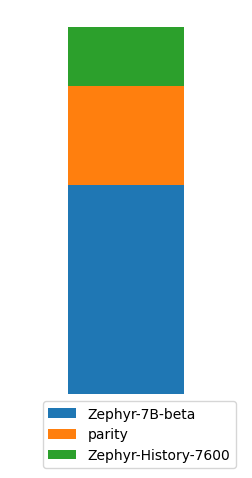

In [78]:
counts = pd.concat(comparison_dfs).groupby(['preferred']).count()['question']
counts = counts.to_dict()

keys = list(counts.keys())
keys = list(set(keys) - {'parity'})
keys = keys[:1] + ['parity'] + keys[1:]
print({k: counts[k] for k in keys})

pd.DataFrame([
    {'rating': k.replace('.answer', ''), 'count': counts[k]} for k in keys
]).set_index('rating').T.plot.bar(stacked=True, figsize=(3, 5), legend=False)
plt.axis('off')
plt.legend(bbox_to_anchor=(1.0, 0.0))
plt.show()

In [102]:
from sklearn import metrics as sk_metrics
import itertools

In [103]:
dataset_gpt_preference = ds.load_from_disk("/scratch1/redditqa/cached_datasets/AskHistorians_test_set_100_model_generated_gpt4_preference")
dataset_gpt_preference = dataset_gpt_preference['gpt4-preference']

df = comparison_dfs[0].copy()
df['preferred_jv'] = comparison_dfs[0]['preferred']
df['preferred_sylwester'] = comparison_dfs[1]['preferred']
df = df[["question", "preferred_jv", "preferred_sylwester"]]
df['preferred_gpt'] = dataset_gpt_preference[:len(df)]
df['preferred_gpt'] = df['preferred_gpt'].apply(lambda x: x + '.answer')

# Print all combinations 
for col1, col2 in itertools.product(df.columns, df.columns):
    if not col1 < col2: 
        continue
    if not col1.startswith('preferred_') or not col2.startswith('preferred_'):
        continue
    
    cohen_kapp = metrics = sk_metrics.cohen_kappa_score(df[col1], df[col2])
    agreement_rate = (df[col1] == df[col2]).mean()
    print(f"{col1} vs. {col2}: cohen_kappa={cohen_kapp:.2f}, agreement_rate={agreement_rate:.2f}")

df

preferred_jv vs. preferred_sylwester: cohen_kappa=0.24, agreement_rate=0.56
preferred_gpt vs. preferred_jv: cohen_kappa=0.12, agreement_rate=0.60
preferred_gpt vs. preferred_sylwester: cohen_kappa=0.04, agreement_rate=0.58


,question,preferred_jv,preferred_sylwester,preferred_gpt
0,Who were some early/Renaissance philosophers w...,parity,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
1,In the United States many poorer States tend t...,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
2,Are there any good sources on the internet tha...,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
3,Why did Carpathian Ruthenia become part of Cze...,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
4,Did Alexander the Great ever intended to conqu...,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
5,Where did pre-modern bakers and brewers get th...,Zephyr-History-7600.answer,Zephyr-7B-beta.answer,Zephyr-7B-beta.answer
6,A massive exodus of Arabic-speaking Jews to Is...,Zephyr-History-7600.answer,Zephyr-History-7600.answer,Zephyr-7B-beta.answer
7,Why do people think St. Thomas traveled all th...,parity,parity,Zephyr-7B-beta.answer
8,Did Ancient Rome have street names and house n...,Zephyr-7B-beta.answer,parity,Zephyr-7B-beta.answer
9,What was Roman contact like with the rest of t...,Zephyr-History-7600.answer,parity,Zephyr-7B-beta.answer
